# Final Project -- Who Drive The Market? 
## 台灣三大法人行為對股價變動之機器學習研究--以半導體產業為例

### Import necessary dictionary & model

In [151]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor, GradientBoostingClassifier, VotingClassifier, StackingClassifier
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix, RocCurveDisplay

import warnings
warnings.filterwarnings("ignore")

### Read csv

In [152]:
stock_price = pd.read_csv('stock_price.csv')
juridical_person = pd.read_csv('juridical_person.csv')
juridical_person.drop(['代號','名稱','年月日'], axis=1, inplace=True)
stock_info = pd.concat([stock_price,juridical_person],axis = 1)

stock_info.columns

Index(['代號', '名稱', '年月日', '收盤價(元)', '成交量(千股)', '外資買賣超(張)', '投信買賣超(張)',
       '自營買賣超(張)', '合計買賣超(張)', '外資買超(張)', '外資賣超(張)', '投信買超(張)', '投信賣超(張)',
       '自營買超(張)', '自營賣超(張)', '三大法人買超(張)', '三大法人賣超(張)', '外資成交比重', '投信成交比重',
       '自營成交比重', '一般現股成交比重'],
      dtype='object')

### Data Cleaning

In [158]:
#rename column name
rename_map = {
    '代號': 'stock_id',
    '名稱': 'stock_name',
    '年月日': 'date',
    'Adj Close': 'adj_close',
    '收盤價(元)': 'adj_close',
    '成交量(千股)': 'volume',
    '外資買超(張)': 'foreign_buy',
    '外資賣超(張)': 'foreign_sell',
    '外資買賣超(張)': 'foreign_net',
    '投信買超(張)': 'trust_buy',
    '投信賣超(張)': 'trust_sell',
    '投信買賣超(張)': 'trust_net',
    '自營買超(張)': 'dealer_buy',
    '自營賣超(張)': 'dealer_sell',
    '自營買賣超(張)': 'dealer_net',
    '合計買賣超(張)':'total_net',
    '三大法人買超(張)':'total_buy',
    '三大法人賣超(張)':'total_sell',
    '外資成交比重':'foreign_precent',
    '投信成交比重':'trust_precent',
    '自營成交比重':'dealer_precent',
    '一般現股成交比重':'total_precent'
}

stock_info = stock_info.rename(columns={k: v for k, v in rename_map.items() if k in stock_info.columns})

#fill null
stock_info = stock_info.dropna(subset=['stock_id'])
stock_info = stock_info.fillna(0)

#astype
num_cols = [
    'stock_id', 'adj_close', 'volume',
    'foreign_sell', 'foreign_net',
    'trust_buy', 'trust_sell', 'trust_net',
    'dealer_buy', 'dealer_sell', 'dealer_net',
    'total_net', 'total_buy', 'total_sell',
    'foreign_precent', 'trust_precent', 'dealer_precent', 'total_precent'
]
stock_info[num_cols] = stock_info[num_cols].replace({',': ''}, regex=True)
stock_info[num_cols] = stock_info[num_cols].astype(float)

In [168]:
#calculate 3-days return
stock_info['return_3d'] = (stock_info.groupby('stock_id')['adj_close'].shift(-3) / stock_info['adj_close'] - 1)

# calculate montmentum
stock_info['foreign_precent_ma3'] = stock_info.groupby('stock_id')['foreign_precent'].transform(lambda x: x.rolling(3).mean().shift(1))
stock_info['foreign_precent_ma3'] = stock_info['foreign_precent_ma3'].fillna(0)
stock_info['momentum_3d'] = stock_info.groupby('stock_id')['adj_close'].transform(lambda x: x.pct_change(3).shift(1))
stock_info['momentum_5d'] = stock_info.groupby('stock_id')['adj_close'].transform(lambda x: x.pct_change(5).shift(1))
stock_info['momentum_3d'] = stock_info['momentum_3d'].fillna(0)
stock_info['momentum_5d'] = stock_info['momentum_5d'].fillna(0)

#lag columns
df = stock_info.sort_values(['stock_id','date']).copy()
lag_cols = [
    'adj_close', 'volume',
    'foreign_net','trust_net','dealer_net','total_net',
    'foreign_precent','trust_precent','dealer_precent','total_precent'
]
for c in lag_cols:
    df[f'{c}_lag1'] = df.groupby('stock_id')[c].shift(1)

# calculate price up day
df['price_up'] = df['adj_close'] > df['adj_close_lag1']
df['price_up'] = df['price_up'].shift(1)
df['price_up_streak'] = df.groupby('stock_id')['price_up'].apply(
    lambda x: x.groupby((x != x.shift()).cumsum()).cumcount() + 1
).reset_index(level=0, drop=True)
df.loc[~df['price_up'].fillna(False), 'price_up_streak'] = 0

feature_cols = [f'{c}_lag1' for c in lag_cols]
target_col = 'return_3d'
df_model = df.dropna(subset=feature_cols + [target_col]).copy()
df_model.to_csv('model.csv', index=False)


In [173]:
df_model = pd.read_csv('model.csv')
df_model

,stock_id,stock_name,date,adj_close,volume,foreign_net,trust_net,dealer_net,total_net,foreign_buy,...,foreign_net_lag1,trust_net_lag1,dealer_net_lag1,total_net_lag1,foreign_precent_lag1,trust_precent_lag1,dealer_precent_lag1,total_precent_lag1,price_up,price_up_streak
0,2302.0,麗正,2024/08/15,16.2559,183.0,177.0,340.0,27.0,544.0,177,...,-31.0,0.0,0.0,-31.0,20.89,0.00,0.00,78.95,True,2
1,2302.0,麗正,2024/08/16,16.4489,291.0,-74.0,0.0,-5.0,-79.0,0,...,177.0,340.0,27.0,544.0,39.92,6.93,0.80,52.13,False,0
2,2302.0,麗正,2024/08/19,16.4489,119.0,-288.0,-3.0,-195.0,-486.0,0,...,-74.0,0.0,-5.0,-79.0,37.59,0.00,0.55,61.81,True,1
3,2302.0,麗正,2024/08/20,16.3041,180.0,-1689.0,-84.0,-266.0,-2039.0,0,...,-288.0,-3.0,-195.0,-486.0,28.28,0.01,1.64,69.84,False,0
4,2302.0,麗正,2024/08/21,16.2077,152.0,52.0,0.0,2.0,54.0,52,...,-1689.0,-84.0,-266.0,-2039.0,49.34,0.71,6.66,43.27,False,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20092,8271.0,宇瞻,2025/08/04,56.0000,704.0,411.0,0.0,-46.0,365.0,411,...,-57.0,-1.0,3.0,-55.0,45.20,0.40,2.70,51.69,False,0
20093,8271.0,宇瞻,2025/08/05,56.7000,1123.0,54.0,0.0,0.0,54.0,54,...,411.0,0.0,-46.0,365.0,48.61,0.00,1.95,49.42,False,0
20094,8271.0,宇瞻,2025/08/06,55.1000,869.0,138.0,0.0,-53.0,85.0,138,...,54.0,0.0,0.0,54.0,31.55,0.00,0.36,67.95,True,1
20095,8271.0,宇瞻,2025/08/07,58.6000,3252.0,916.0,0.0,0.0,916.0,916,...,138.0,0.0,-53.0,85.0,24.63,0.00,3.38,71.88,False,0


## Visualize Data

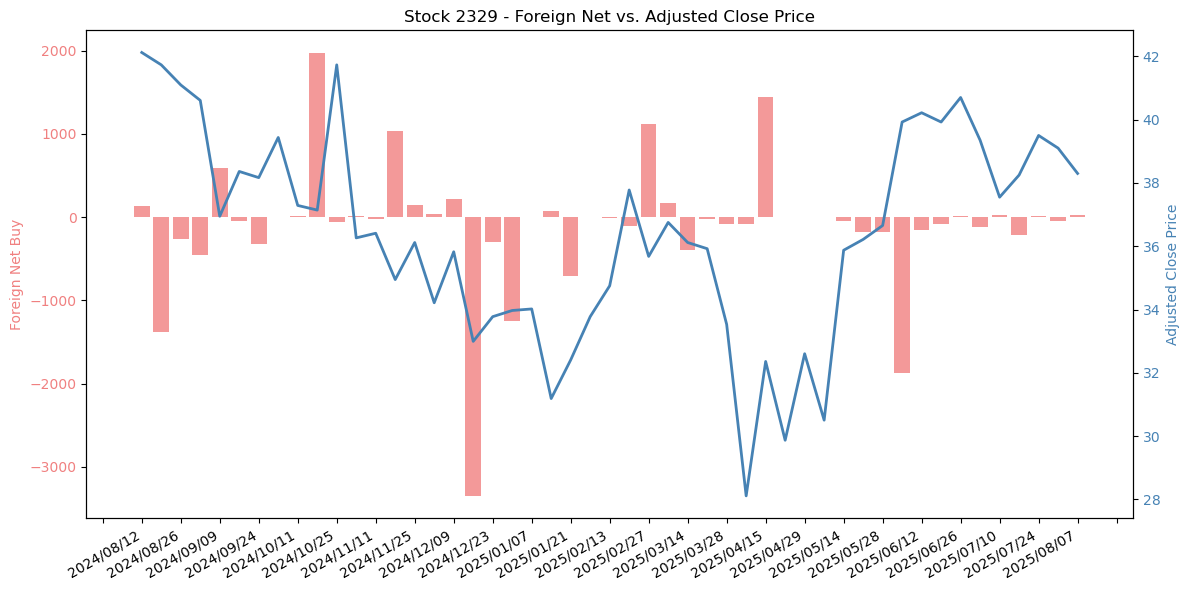

In [169]:
#pick random stock-2329

stock_id =2329
df = stock_info[stock_info['stock_id'] == stock_id].sort_values('date')
df_downsampled = df.iloc[::5, :]

fig, ax1 = plt.subplots(figsize=(12, 6))

# left y-axis
ax1.xaxis.set_major_locator(mdates.DayLocator(interval=2))
ax1.bar(df_downsampled['date'], df_downsampled['foreign_net'],  color='lightcoral', alpha = 0.8)
ax1.set_ylabel('Foreign Net Buy', color='lightcoral')
ax1.tick_params(axis='y', labelcolor='lightcoral')

# right y-axis
ax2 = ax1.twinx()
ax2.plot(df_downsampled['date'], df_downsampled['adj_close'], color='steelblue', label='Adj Close', linewidth=2)
ax2.set_ylabel('Adjusted Close Price', color='steelblue')
ax2.tick_params(axis='y', labelcolor='steelblue')



plt.title(f'Stock {stock_id} - Foreign Net vs. Adjusted Close Price')
fig.autofmt_xdate()
fig.tight_layout()
plt.show()


### Train

In [172]:
# read data
df_model = pd.read_csv('model.csv')

#feature
df_model['net_positive'] = df_model['total_net'] > 0
df_model['pos_streak'] = df_model.groupby('stock_id')['net_positive'].apply(
    lambda x: x.groupby((x != x.shift()).cumsum()).cumcount() + 1
).reset_index(level=0, drop=True)
df_model.loc[~df_model['net_positive'], 'pos_streak'] = 0

# target
df_model['target'] = (df_model['return_3d'] > 0).astype(int)

# model
X = df_model[[ 'dealer_net', 'dealer_precent',
    'foreign_net', 'trust_net',
    'foreign_precent', 'trust_precent', 
    'total_precent', 'pos_streak'
]]
y = df_model['target']

# split
X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=False, test_size=0.2)


base_learners = [
    ('rf', RandomForestClassifier(
    n_estimators=300,
    max_depth=5,
    min_samples_split=10,
    min_samples_leaf=5,
    max_features='sqrt',
    random_state=42
)),
    ('et', ExtraTreesClassifier(
    n_estimators=200,       
    max_depth=None,         
    min_samples_split=2,   
    min_samples_leaf=1,     
    max_features='sqrt',    
    bootstrap=False,        
    random_state=42
)),
    ('gb',  GradientBoostingClassifier(
    n_estimators=200,
    learning_rate=0.05,
    max_depth=4,
    subsample=0.8,
    random_state=42
))
]

meta_learner = LogisticRegression(max_iter=2000)

stack_model = StackingClassifier(
    estimators=base_learners,
    final_estimator=meta_learner,
    cv=5,              
    passthrough=True   
)

stack_model.fit(X_train, y_train)

# predict
y_pred = stack_model.predict(X_test)
y_proba = stack_model.predict_proba(X_test)[:, 1]

print(classification_report(y_test, y_pred))
print('AUC:', roc_auc_score(y_test, y_proba))

              precision    recall  f1-score   support

           0       0.52      0.50      0.51      1932
           1       0.56      0.58      0.57      2088

    accuracy                           0.54      4020
   macro avg       0.54      0.54      0.54      4020
weighted avg       0.54      0.54      0.54      4020

AUC: 0.5462235400157064


In [170]:
# read data
df_model = pd.read_csv('model.csv')

#feature
df_model['net_positive'] = df_model['total_net'] > 0
df_model['pos_streak'] = df_model.groupby('stock_id')['net_positive'].apply(
    lambda x: x.groupby((x != x.shift()).cumsum()).cumcount() + 1
).reset_index(level=0, drop=True)
df_model.loc[~df_model['net_positive'], 'pos_streak'] = 0

# target
df_model['target'] = (df_model['return_3d'] > 0).astype(int)

# model
X = df_model[[ 'foreign_precent_ma3','price_up_streak',
    'foreign_net', 'trust_net',
    'foreign_precent', 'trust_precent', 
    'total_precent', 'pos_streak'
]]

y = df_model['target']

# split
X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=False, test_size=0.2)


base_learners = [
    ('rf', RandomForestClassifier(
    n_estimators=300,
    max_depth=5,
    min_samples_split=10,
    min_samples_leaf=5,
    max_features='sqrt',
    random_state=42
)),
    ('et', ExtraTreesClassifier(
    n_estimators=200,       
    max_depth=None,         
    min_samples_split=2,   
    min_samples_leaf=1,     
    max_features='sqrt',    
    bootstrap=False,        
    random_state=42
)),
    ('gb',  GradientBoostingClassifier(
    n_estimators=200,
    learning_rate=0.05,
    max_depth=4,
    subsample=0.8,
    random_state=42
))
]

meta_learner = LogisticRegression(max_iter=2000)

stack_model = StackingClassifier(
    estimators=base_learners,
    final_estimator=meta_learner,
    cv=5,              
    passthrough=True   
)


stack_model.fit(X_train, y_train)

# predict
y_pred = stack_model.predict(X_test)
y_proba = stack_model.predict_proba(X_test)[:, 1]

print(classification_report(y_test, y_pred))
print('AUC:', roc_auc_score(y_test, y_proba))

              precision    recall  f1-score   support

           0       0.73      0.57      0.64      1932
           1       0.67      0.80      0.73      2088

    accuracy                           0.69      4020
   macro avg       0.70      0.69      0.69      4020
weighted avg       0.70      0.69      0.69      4020

AUC: 0.7417657738591021


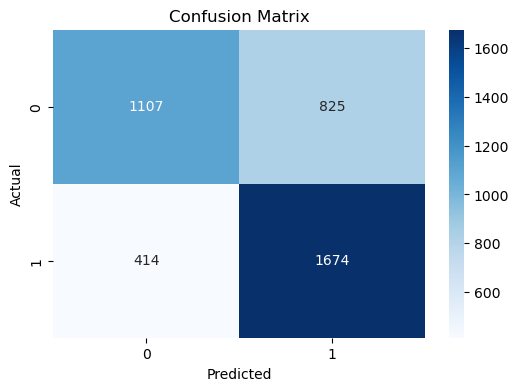

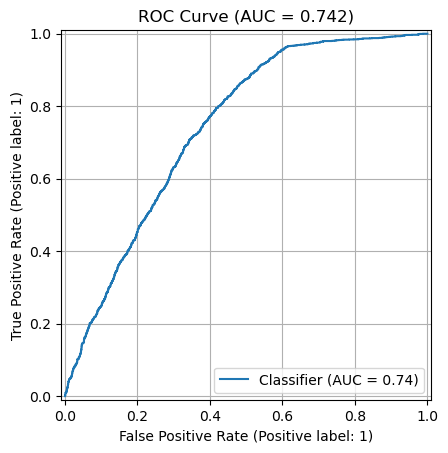

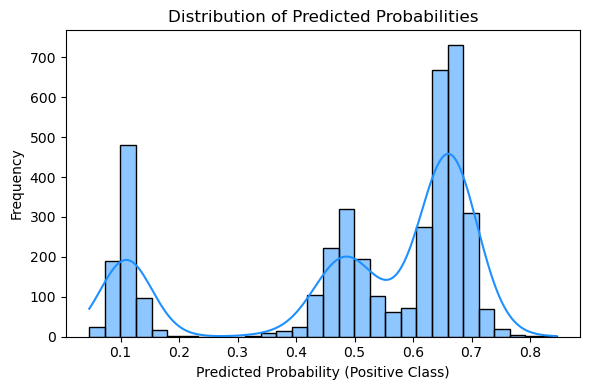

In [171]:
# 1) visualize confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=[0, 1], yticklabels=[0, 1])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# 2) visualize ROC curve
RocCurveDisplay.from_predictions(y_test, y_proba)
plt.title(f"ROC Curve (AUC = {roc_auc_score(y_test, y_proba):.3f})")
plt.grid(True)
plt.show()

# Probability
plt.figure(figsize=(6, 4))
sns.histplot(y_proba, bins=30, kde=True, color='dodgerblue')
plt.title('Distribution of Predicted Probabilities')
plt.xlabel('Predicted Probability (Positive Class)')
plt.ylabel('Frequency')
plt.tight_layout()
plt.show()